# Setup

In [1]:
!pip install fastai > /dev/null

In [1]:
import pandas as pd
import seaborn as sns

from fastai import callback
from fastai.tabular.all import *

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [93]:
# Display
# pd.options.display.max_colwidth = 100
# pd.options.display.max_columns = 100
# pd.options.display.max_rows = 250
# sns.set(style="whitegrid")
# sns.set_context(context="paper")

In [2]:
pd_clean_train = pd.read_csv("./data/clean/train.csv", index_col='PassengerId')
pd_clean_test = pd.read_csv("./data/clean/test.csv", index_col='PassengerId')
pd_sample_submission = pd.read_csv("../input/sample_submission.csv")

In [3]:
pd_clean_train.info()
pd_clean_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S


# Create Modeling Datasets

In [36]:
CONT_FEATS = ['Age', 'SibSp', 'Parch', 'Fare']
CAT_FEATS = ['Sex', 'Embarked']


def format_dataset(pd_df):
    dataset_cols = CONT_FEATS + CAT_FEATS + ['Survived']
    
    return pd_df.loc[:, [col for col in dataset_cols if col in pd_df.columns]]


def transform_survived_col(pd_df):
    return pd_df.assign(Survived=pd_df.Survived.astype(np.float16))

In [37]:
pd_model_train = (pd_clean_train
    .pipe(transform_survived_col)
    .pipe(format_dataset))
pd_model_test = (pd_clean_test
    .pipe(format_dataset))

# Train-Validation Split

In [38]:
pd_train = pd_model_train.sample(frac = 0.8, random_state=3)
pd_valid = pd_model_train.drop(pd_train.index)

# Create Modeling Dataset

In [39]:
splits = (list(pd_train.index.values), list(pd_valid.index.values))
procs = [Categorify, FillMissing, Normalize]

In [40]:
tp_train = TabularPandas(
    df=pd_model_train, 
    procs=procs, 
    cat_names=CAT_FEATS, 
    cont_names=CONT_FEATS, 
    y_names='Survived', 
    splits=splits)

In [41]:
# Save
save_pickle('./data/model/nn_tp_train.pkl', tp_train)

In [42]:
# Read
tp_train = pickle.load(open('./data/model/nn_tp_train.pkl', "rb"))

In [43]:
print("Raw Input:")
tp_train.show(3)
print("Preprocessed Input:")
tp_train.items.head(3)

Raw Input:


,Sex,Embarked,Age_na,Fare_na,Age,SibSp,Parch,Fare,Survived
PassengerId,,,,,,,,,
79528,male,S,False,False,23.0,0.0,0.0,26.090000,0.0
53876,female,S,False,False,32.0,0.0,0.0,151.880005,1.0
9777,male,S,False,False,31.0,0.0,0.0,26.629999,0.0


Preprocessed Input:


,Age,SibSp,Parch,Fare,Sex,Embarked,Survived,Age_na,Fare_na
PassengerId,,,,,,,,,
79528,-0.852602,-0.461851,-0.478886,-0.256052,2,3,0.0,1,1
53876,-0.353211,-0.461851,-0.478886,1.555831,1,3,1.0,1,1
9777,-0.408699,-0.461851,-0.478886,-0.248274,2,3,0.0,1,1


# Train Model

In [74]:
# Define model
dls = tp_train.dataloaders(1024)
learner = tabular_learner(
    dls=dls, 
    y_range=(0,1), 
    metrics=accuracy,
    loss_func=nn.SoftMarginLoss(),  #nn.L1Loss()
    layers=[500, 250],
    cbs=callback.all.ShowGraphCallback)

CPU times: user 8 s, sys: 3.53 s, total: 11.5 s
Wall time: 2.99 s


SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.001737800776027143)

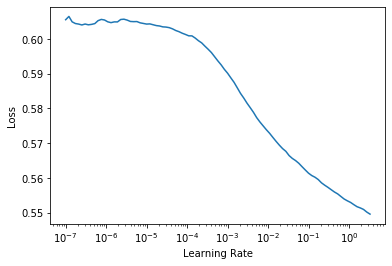

In [75]:
%%time
# Find optimal learning rate
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.530724,0.531354,0.574100,00:02
1,0.530207,0.531354,0.574100,00:02
2,0.530387,0.531354,0.574100,00:02
3,0.530397,0.531354,0.574100,00:02
4,0.530465,0.531354,0.574100,00:02


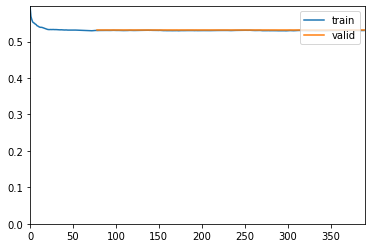

CPU times: user 35.5 s, sys: 15.7 s, total: 51.2 s
Wall time: 13 s


In [76]:
%%time
# Fit model
learner.fit_one_cycle(5, lr_max=10e-1)

In [52]:
# Save model
!rm ./models/nn.pth  # remove previously saved model
learner.save('nn')  # automatically prefixes "./models/"

Path('models/nn.pth')

In [53]:
# Read model
learner.load('nn')  # automatically prefixes "./models/"
learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=16, out_features=1000, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1000, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=15, bias=False)
      (2): ReLU(inplace=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=15, out_f

# Evaluate Model

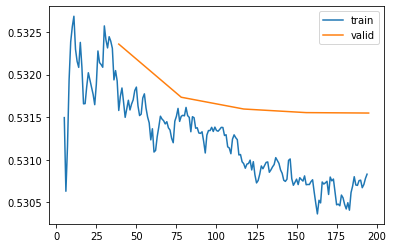

In [58]:
learner.recorder.plot_loss()

# Create Submission

In [32]:
# Process test dataset
tp_test = tp_train.new(pd_model_test)
tp_test.process()
tst_dl = dls.valid.new(tp_test)

In [33]:
# Compute predictions
preds, _ = learner.get_preds(dl=tst_dl)
labels = [pred.item() for pred in np.argmax(preds, 1)]

In [34]:
# Create sumbission dataset
pd_submission = pd_sample_submission.assign(Survived=labels)
pd_submission.to_csv('./submissions/2.1-modelling-fastai.csv', index=False)